# Tanzanian Water Wells


## Problem Description

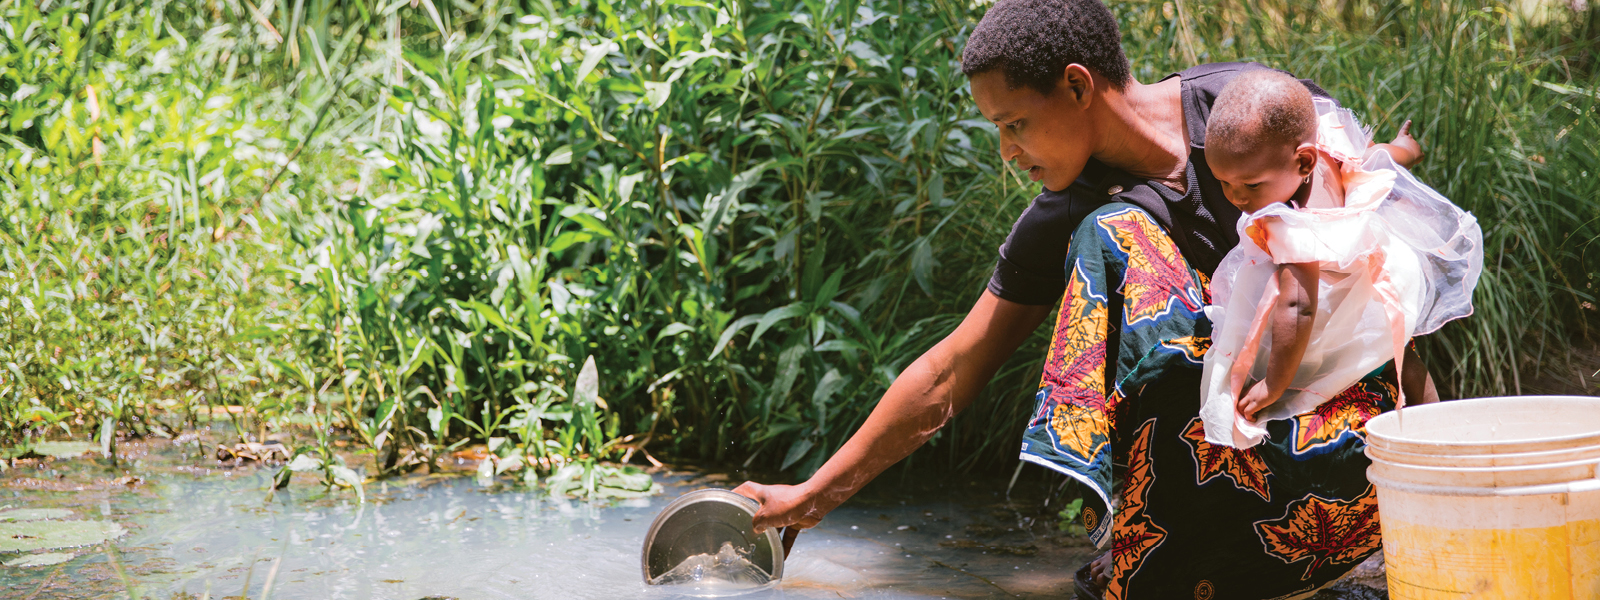

Water Aid is an NGO based in the United Kingdom that works on access to clean water around the world. They consider access to clean water, decent toilets and good hygiene as basic human rights. For over 30 years, they have been working in partnership to improve access to these three essentials through a combination of programmatic and policy work.

Water Aid works in several countries around the globe, including Tanzania. According to the World Sector Report (2019) around 60% of Tanzanians have access to improved water, but the degree of water access, and the water quality and quantity, varies. Drought, landscape change, and the amplifying effects of climate change are straining existing surface water supplies. 

Water Aid is launching a program to repair non-functioning wells in the cross country shared water basins of Eastern Africa. The status of the wells is not clearly recorded in countries surrounding Tanzania. Identifying non-functioning wells, securing funding, and traveling to these rural locations to repair wells is both time and resource intensive. They need a predictive model that accurately identifies which wells are not functioning to reduce cost and ensure they are using their resources wisely. They also need to identify a specific water basin to begin their work.


### Goals

There are three data science goals to address Water Aid's need for accurately identifying non-functioning wells:

1. Using an iterative process, build a predictive machine learning model based on existing water well data to accurately classify non-functioning wells.


2. Deliver two recommendations to Water Aid: a specific transboundary water basin to begin their operations, and one feature characteristic of the wells in this basin that will lead to higher chance of identifying non-functioning wells. 


#### Load Packages and Data

In [426]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [427]:
# Load the predictor data

wells = pd.read_csv('training_set_values.csv')
wells.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [428]:
# Load the target data

target = pd.read_csv('training_set_labels.csv')

target.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


## 1. Exploratory Data Analysis

Get a sense of the big picture for the dataset. Prepare the data for further analysis. Gain an understanding of the variables, or predictors in this case. Study the relationship between variables. Make plan for initial model. 

In [429]:
# Identify size of dataset

print("Records for wells:", wells.shape)
print()
print("Records for target:", target.shape)

Records for wells: (59400, 40)

Records for target: (59400, 2)


In [430]:
# Identify datatypes and record amount for each predictor

wells.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [431]:
# Examine numerical predictors mean, min, max

wells.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [432]:
# Missing data total
wells.isna().sum().sum()

46094

In [433]:
# Missing data by predictor

wells.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [434]:
# Data missing for target
target.isna().sum()

id              0
status_group    0
dtype: int64

In [435]:
# Examine value counts for the target, consider imbalance in target data
target['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [436]:
# Percentage makeup of target values
print("Functional percentage:", round(32259/59400*100, 2))
print("Non functional percentage:", round(22824/59400*100, 2))
print("Functional needs repair percentage:", round(4317/59400*100, 2))

Functional percentage: 54.31
Non functional percentage: 38.42
Functional needs repair percentage: 7.27


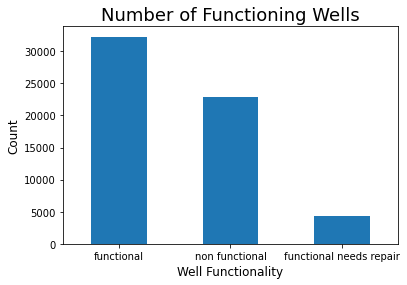

<Figure size 432x288 with 0 Axes>

In [437]:
# Visually plot target variable counts

target.status_group.value_counts().plot(kind="bar")
plt.title("Number of Functioning Wells",fontsize= 18)
plt.xlabel("Well Functionality", fontsize = 12)
plt.xticks(rotation=0)
plt.ylabel("Count", fontsize = 12)
plt.show();

plt.savefig('Number of Functioning Wells')

In [438]:
# Identify unique values per column
print(wells.nunique())

id                       59400
amount_tsh                  98
date_recorded              356
funder                    1897
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37400
num_private                 65
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_

In [439]:
# Concatenate preds and target for heatmap 

df = pd.concat([wells, target], axis =1)

df = df.loc[:,~df.columns.duplicated()].copy()

df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


#### Correlation of numeric data

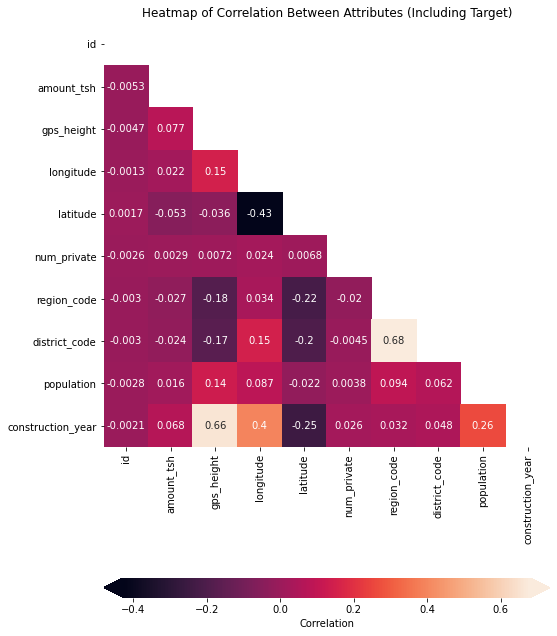

In [440]:
# Create a heatmap to examine the correlational coefficents


corr = df.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(8, 12))

# Plot a heatmap of the correlations

sns.heatmap(
    
    data=corr,
    
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    
    ax=ax,
    
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

AxesSubplot(0.125,0.125;0.775x0.755)


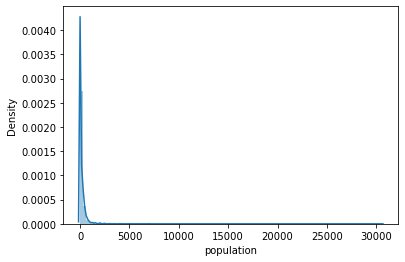

In [441]:
# Check distribution for numeric data
import warnings
warnings.filterwarnings('ignore')

print(sns.distplot(wells.population, bins = 100))



<AxesSubplot:xlabel='population'>

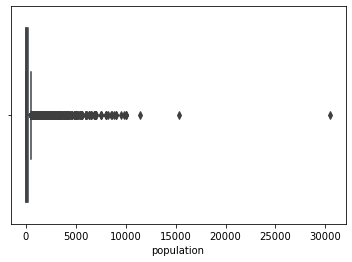

In [442]:
# Identify range of population and any outliers

sns.boxplot(wells.population)


In [443]:
# Identify population counts
print(wells.population.value_counts())
print(wells.population.nunique())

0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
3241        1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1049, dtype: int64
1049


#### Total Static Head data

count     59400.000000
mean        317.650385
std        2997.574558
min           0.000000
25%           0.000000
50%           0.000000
75%          20.000000
max      350000.000000
Name: amount_tsh, dtype: float64


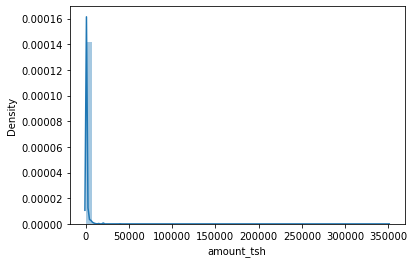

In [444]:
# Plot and descrive total static head

sns.distplot(wells.amount_tsh)

print(wells.amount_tsh.describe())


<AxesSubplot:xlabel='amount_tsh'>

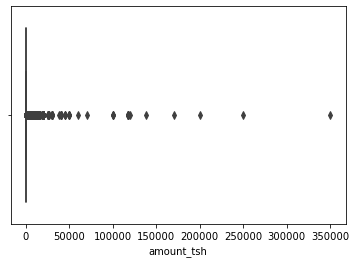

In [445]:
# Identify range and outliers of total static head

sns.boxplot(wells.amount_tsh)

In [446]:
# Identify how many wells do not have static head

print(wells.amount_tsh.value_counts())

0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64


#### Geographic Data

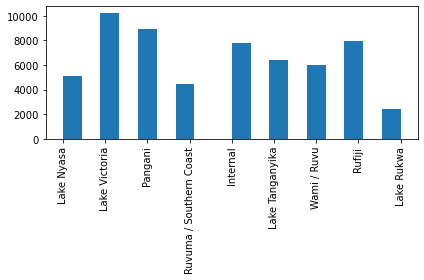

In [447]:
# plot basins
fig, axs = plt.subplots(1, 1,
                        figsize =(6, 4),
                        tight_layout = True)
 
axs.hist(wells.basin, bins = 18)
plt.xticks(rotation = 90)

plt.show()

In [448]:
# How many wells are in each basin

wells.basin.value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

In [449]:

wells.region.value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [450]:
wells.district_code.value_counts()

1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64

In [451]:
wells.region_code.value_counts()

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

#### Water attributes

In [452]:
wells.water_quality.value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [453]:
wells.quality_group.value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

In [454]:
wells.quantity.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [455]:
wells.quantity_group.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

In [456]:
wells.scheme_name.value_counts()

K                               682
None                            644
Borehole                        546
Chalinze wate                   405
M                               400
                               ... 
Mws                               1
Mpal                              1
Malemeo gravity water supply      1
Bulenya water supply              1
UNICRF                            1
Name: scheme_name, Length: 2696, dtype: int64

In [457]:
wells.scheme_management.value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [458]:
wells.extraction_type.value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [459]:
wells.extraction_type_group.value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [460]:
wells.extraction_type_class.value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [461]:
wells.source.value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [462]:
wells.source_type.value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [463]:
wells.waterpoint_type_group.value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [464]:
wells.source_class.value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

In [465]:
wells.waterpoint_type.value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

#### Organizational attributes

In [466]:
wells.funder.value_counts()

Government Of Tanzania         9084
Danida                         3114
Hesawa                         2202
Rwssp                          1374
World Bank                     1349
                               ... 
Fida                              1
Kigoma Municipal Council          1
Abc-ihushi Development Cent       1
Tag Church Ub                     1
Nyamingu Subvillage               1
Name: funder, Length: 1897, dtype: int64

In [467]:
wells.num_private.value_counts()

0      58643
6         81
1         73
5         46
8         46
       ...  
180        1
213        1
23         1
55         1
94         1
Name: num_private, Length: 65, dtype: int64

In [468]:
wells.permit.value_counts()

True     38852
False    17492
Name: permit, dtype: int64

In [469]:
wells.management.value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [470]:
wells.management_group.value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

In [471]:
wells.payment.value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [472]:
wells.payment_type.value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

In [473]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(wells[1000:1020])

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
1000,47384,250.0,2013-02-14,Oxfam,1409,OXFAM,30.105401,-4.367134,Ofisi Ya Kijiji,0,Lake Tanganyika,Kamana,Kigoma,16,2,Kasulu,Munyegera,620,True,GeoData Consultants Ltd,Water authority,Mtobo,True,1996,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
1001,11570,0.0,2012-10-12,Resolute Mining,0,Consulting Engineer,33.210098,-4.049685,Igabanilo,0,Internal,Mwatandai,Tabora,14,1,Nzega,Lusu,0,False,GeoData Consultants Ltd,VWC,NaN,False,0,afridev,afridev,handpump,vwc,user-group,never pay,never pay,salty,salty,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018,41433,0.0,2011-03-05,Government Of Tanzania,1307,DWE,38.325050,-4.464609,Kwa Mzee Noa,0,Pangani,Lugwashi,Tanga,4,1,Lushoto,Mbaramo,1,True,GeoData Consultants Ltd,VWC,Shagai streem,True,1985,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1019,21810,0.0,2013-01-17,Bulyahunlu Gold Mine,0,Bulyahunlu Gold Mine,32.370100,-3.281536,Ibanza,0,Lake Tanganyika,Ibanza,Shinyanga,17,3,Kahama,Bugarama,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,other,other,other,vwc,user-group,unknown,unknown,milky,milky,enough,enough,shallow well,shallow well,groundwater,other,other


## 2. Preprocess data, Initial Model

Redundant data columns where the data is included in other columns that contain more expansive information should be dropped: water attributes, geographic attributes,  include water include regional columns, water extraction and source types.

Drop columns that do not contribute to the model. These include water id, names of the waterpoint, names of subvillages.  

Make plan for missing categorical and numeric data.

In [474]:
# Drop redundant data columns and columns that do not contribute to model, i.e. names.
wells.drop(columns = ['id', 'wpt_name', 'region', 'recorded_by', 'scheme_name', 
           'scheme_management', 'extraction_type_group', 'payment_type', 'subvillage',
           'quality_group', 'quantity_group', 'source_type', 'waterpoint_type'], inplace = True)


In [475]:
wells.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'num_private', 'basin', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'water_quality', 'quantity', 'source', 'source_class',
       'waterpoint_type_group'],
      dtype='object')

In [476]:
# Check missing data
wells.isna().sum()

amount_tsh                  0
date_recorded               0
funder                   3635
gps_height                  0
installer                3655
longitude                   0
latitude                    0
num_private                 0
basin                       0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting           3334
permit                   3056
construction_year           0
extraction_type             0
extraction_type_class       0
management                  0
management_group            0
payment                     0
water_quality               0
quantity                    0
source                      0
source_class                0
waterpoint_type_group       0
dtype: int64

In [477]:
# Replace Nan in public_meeting and permit as False

wells['public_meeting'] = wells['public_meeting'].fillna('False').astype('bool')
wells.public_meeting.head()

0    True
1    True
2    True
3    True
4    True
Name: public_meeting, dtype: bool

In [478]:
# replace missing permit data as False
wells['permit'] = wells['permit'].fillna('False').astype('bool')
wells.permit.head()

0    False
1     True
2     True
3     True
4     True
Name: permit, dtype: bool

In [479]:
# Convert "date_recorded" to month_recorded

import datetime 

wells['date_recorded'] = pd.to_datetime(wells['date_recorded'])
wells['month_recorded'] = wells['date_recorded'].dt.month
wells['month_recorded']

0        3
1        3
2        2
3        1
4        7
        ..
59395    5
59396    5
59397    4
59398    3
59399    3
Name: month_recorded, Length: 59400, dtype: int64

In [480]:
wells.drop('date_recorded', axis = 1, inplace = True)

#### Initial Model - Logistic Regression 

Use a Logistic Regression model in a pipeline for initial model results.

In [481]:
# Assign the predictors and target
X = wells
y = target['status_group']

In [482]:
# Perform a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [483]:
X_train.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'num_private', 'basin', 'region_code', 'district_code',
       'lga', 'ward', 'population', 'public_meeting', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_class',
       'management', 'management_group', 'payment', 'water_quality',
       'quantity', 'source', 'source_class', 'waterpoint_type_group',
       'month_recorded'],
      dtype='object')

In [484]:
# Examine data types and record counts
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44550 entries, 24947 to 56422
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             44550 non-null  float64
 1   funder                 41859 non-null  object 
 2   gps_height             44550 non-null  int64  
 3   installer              41850 non-null  object 
 4   longitude              44550 non-null  float64
 5   latitude               44550 non-null  float64
 6   num_private            44550 non-null  int64  
 7   basin                  44550 non-null  object 
 8   region_code            44550 non-null  int64  
 9   district_code          44550 non-null  int64  
 10  lga                    44550 non-null  object 
 11  ward                   44550 non-null  object 
 12  population             44550 non-null  int64  
 13  public_meeting         44550 non-null  bool   
 14  permit                 44550 non-null  bool   
 15

In [539]:


# create subpipe for numeric data

subpipe_num = Pipeline(steps=[('num_impute', SimpleImputer()),
                           ('ss', StandardScaler())])

# create subpipe for categorical data, use SimpleImputer for 'missing' data.

subpipe_cat = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='constant', fill_value = 'missing')),
                             ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

# combine subpipes into ColumnTransformer

CT = ColumnTransformer(transformers=[('subpipe_num', subpipe_num, [0, 2, 4, 5, 12]),
                                    ('subpipe_cat', subpipe_cat, [1, 3, 6, 7, 8, 9, 10, 
                                                                  11, 13, 14, 15, 16,
                                                                  17, 18, 19, 20, 21, 
                                                                  22, 23, 24, 25, 26])],
                           remainder='passthrough')



In [540]:
#Perform Logistic Regression for initial model

log_reg_pipe = Pipeline(steps = [('ct', CT), 
                           ('log_reg', LogisticRegression(random_state = 42))])

In [541]:
# Fit the logistic regression model
log_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [0, 2, 4, 5, 12]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                             

#### Evaluate initial model

In [542]:
# Score the log reg model
log_reg_pipe.score(X_train, y_train)

0.8025813692480359

In [543]:
# create predicted target variable
y_hat = log_reg_pipe.predict(X_test)

In [544]:
# Generate log_reg classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_hat))

                         precision    recall  f1-score   support

             functional       0.78      0.88      0.83      8098
functional needs repair       0.55      0.25      0.34      1074
         non functional       0.80      0.74      0.77      5678

               accuracy                           0.78     14850
              macro avg       0.71      0.62      0.65     14850
           weighted avg       0.77      0.78      0.77     14850



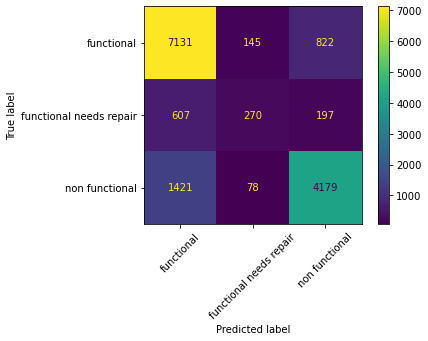

In [545]:
plot_confusion_matrix(log_reg_pipe, X_test, y_test, xticks_rotation=45);

In [546]:
# Save model in Joblib
from joblib import Parallel, delayed
import joblib

import pickle
  
# Save the model as a pickle in a file
joblib.dump(log_reg_pipe, 'log_reg.pkl')
  
# Load the model from the file
#log_reg_from_joblib = joblib.load('log_reg.pkl')
  
# Use the loaded model to make predictions
#log_reg_from_joblib.predict(X_test)

['log_reg.pkl']

## 3. Decision Tree Model with Parameter Tuning

Considering the dataset a decision tree would be a useful secondary model. Use hyperparameter tuning to improve upon the initial logistic regression model.

In [547]:
import category_encoders as ce


# create subpipe for numeric data

subpipe_num = Pipeline(steps=[('num_impute', SimpleImputer()),
                           ('ss', StandardScaler())])

# create subpipe for categorical data, use SimpleImputer for 'missing' data.

subpipe_cat = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='constant', fill_value = 'missing')),
                             ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

# combine subpipes into ColumnTransformer

CT = ColumnTransformer(transformers=[('subpipe_num', subpipe_num, [0, 2, 4, 5, 12]),
                                    ('subpipe_cat', subpipe_cat, [1, 3, 6, 7, 8, 9, 10, 
                                                                  11, 13, 14, 15, 16,
                                                                  17, 18, 19, 20, 21, 
                                                                  22, 23, 24, 25, 26])],
                           remainder='passthrough')


In [548]:
# Use a decision tree for the secondary model
dtc = DecisionTreeClassifier(random_state = 42)    

dtc_pipe = Pipeline(steps=[('ct', CT), 
                           ('dtc', dtc)])

In [549]:
dtc_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [0, 2, 4, 5, 12]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                             

In [550]:
dtc_pipe.score(X_train, y_train)

0.9984960718294051

In [551]:
dtc_pipe.score(X_test, y_test)

0.7612121212121212

#### Evaluate Decision Tree Model

In [552]:
y_hat = dtc_pipe.predict(X_test)

In [553]:
print(classification_report(y_test, y_hat))

                         precision    recall  f1-score   support

             functional       0.81      0.80      0.80      8098
functional needs repair       0.38      0.39      0.39      1074
         non functional       0.77      0.77      0.77      5678

               accuracy                           0.76     14850
              macro avg       0.65      0.65      0.65     14850
           weighted avg       0.76      0.76      0.76     14850



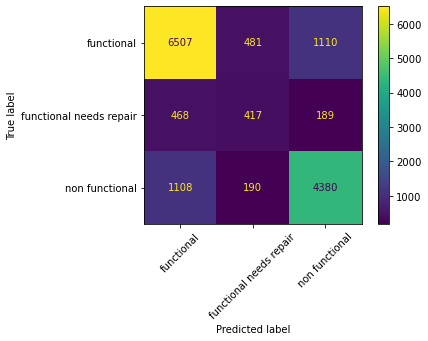

In [554]:
plot_confusion_matrix(dtc_pipe, X_test, y_test, xticks_rotation=45);

In [555]:
len(dtc_pipe.named_steps['dtc'].feature_importances_)

5974

In [556]:
model_tree = dtc_pipe.named_steps['dtc']
model_tree.feature_importances_

array([0.02232117, 0.05443548, 0.12866974, ..., 0.00177732, 0.00037402,
       0.00037427])

In [558]:
# Save the decision tree model as a pickle in a file
joblib.dump(dtc_pipe, 'dtc_pipe.pkl')

['dtc_pipe.pkl']

#### Results 

The decision tree model's accuracy was less than the logistic regression model and did not improve upon the logistic regression accuracy, though the f1-score for non-functional wells of both models remained the same. 

#### Use gridsearch for hyperparameter tuning.

In [75]:
params = {}
params['dtc__criterion'] = ['gini', 'entropy']
params['dtc__min_samples_leaf'] = [1, 3, 5, 7, 10]
params['dtc__max_depth'] = [1,3,5,7,9]
params['dtc__splitter'] = ['best', 'random']

gs = GridSearchCV(estimator=dtc_pipe,
                 param_grid=params,
                 cv=3)

In [76]:
gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         [0, 2,
                                                                          4, 5,
                                                                          12]),
                                                                        ('subpipe_cat',
                 

In [77]:
# Identify the best parameters
gs.best_params_

{'dtc__criterion': 'gini',
 'dtc__max_depth': 9,
 'dtc__min_samples_leaf': 5,
 'dtc__splitter': 'best'}

In [78]:
# Examine cross validation results
gs.cv_results_['mean_test_score']

array([0.6424018 , 0.6424018 , 0.6424018 , 0.6424018 , 0.6424018 ,
       0.6424018 , 0.6424018 , 0.6424018 , 0.6424018 , 0.6424018 ,
       0.69427609, 0.69441077, 0.69427609, 0.69441077, 0.69429854,
       0.69443322, 0.69427609, 0.69445567, 0.69450056, 0.69461279,
       0.71270483, 0.70826038, 0.71261504, 0.70810325, 0.71265993,
       0.70808081, 0.71272727, 0.7081257 , 0.71261504, 0.70808081,
       0.72489338, 0.72282828, 0.72480359, 0.72255892, 0.72455668,
       0.72253648, 0.72453423, 0.72210999, 0.72430976, 0.72190797,
       0.73719416, 0.73476992, 0.73705948, 0.73429854, 0.73748597,
       0.73297419, 0.73643098, 0.73313131, 0.73542088, 0.73236813,
       0.6424018 , 0.6424018 , 0.6424018 , 0.6424018 , 0.6424018 ,
       0.6424018 , 0.6424018 , 0.6424018 , 0.6424018 , 0.6424018 ,
       0.69342312, 0.6935578 , 0.69342312, 0.6935578 , 0.69342312,
       0.6935578 , 0.69342312, 0.69360269, 0.69351291, 0.69362514,
       0.7006734 , 0.69723906, 0.70060606, 0.6973064 , 0.70056

#### Evaluate decision tree gridsearch results

In [79]:
y_hat = gs.predict(X_test)

In [80]:
print(classification_report(y_test, y_hat))

                         precision    recall  f1-score   support

             functional       0.70      0.93      0.80      8098
functional needs repair       0.58      0.15      0.23      1074
         non functional       0.85      0.57      0.68      5678

               accuracy                           0.74     14850
              macro avg       0.71      0.55      0.57     14850
           weighted avg       0.75      0.74      0.72     14850



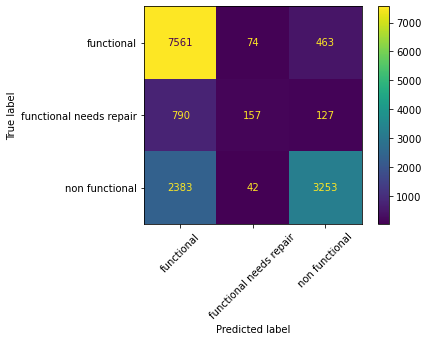

In [81]:
plot_confusion_matrix(gs, X_test, y_test, xticks_rotation = 45);

In [559]:
# Save the model as a pickle in a file
joblib.dump(gs, 'grid_search_dtc.pkl')

['grid_search_dtc.pkl']

#### Results

While accuracy decreased overall, the precision score on non-functional wells improved from 77% to 85%. This could be a good model if we only focus on precision score for non-functioning wells. Wells that need repair precision score also improved by 20%, this opens a path to possibly identify wells that could soon be non-functioning. 

### 4.  Random Forest with SMOTE and Tuning

Use a random forest model to further explore whether the precision or recall score on non-functioning wells can be improved. Address class imbalance issues with SMOTE. Further tune the model using search tools for best hyperparameters. 

In [82]:
# Instantiate a Random Forest Classifier

rfc = RandomForestClassifier(random_state=42)

# Instantiate SMOTE for class imbalance

sm = SMOTE(sampling_strategy = 'auto', random_state = 42)

# Create pipeline

rfc_model_pipe = ImPipeline(steps=[('ct', CT),
                             ('sm', sm),
                            ('rfc', rfc)])


In [83]:
rfc_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [0, 2, 4, 5, 12]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                             

In [84]:
rfc_model_pipe.score(X_train, y_train)

0.9984960718294051

#### Evaluate results on Random Forest

In [85]:
y_hat_rfc = rfc_model_pipe.predict(X_test)

In [86]:
print(classification_report(y_test, y_hat_rfc))

                         precision    recall  f1-score   support

             functional       0.82      0.84      0.83      8098
functional needs repair       0.43      0.43      0.43      1074
         non functional       0.82      0.78      0.80      5678

               accuracy                           0.79     14850
              macro avg       0.69      0.69      0.69     14850
           weighted avg       0.79      0.79      0.79     14850



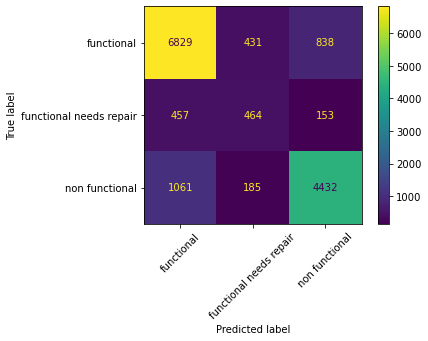

In [87]:
plot_confusion_matrix(rfc_model_pipe, X_test, y_test, xticks_rotation = 45);

In [560]:
# Save the random forest model as a pickle in a file
joblib.dump(rfc_model_pipe, 'rfc_model.pkl')

['rfc_model.pkl']

#### Gridsearch for hyperparameter tuning

In [95]:
# Grid Search for better model criteria 

params = {'rfc__n_estimators': [10],
          'rfc__criterion': ['gini'],
          'rfc__min_samples_leaf': [1, 5, 10],
          'rfc__max_depth': [1, 5, 9],
          'rfc__max_features': [9]
          }

gs_rfc = GridSearchCV(estimator=rfc_model_pipe,
                 param_grid=params, n_jobs = -1,
                 cv=3)

In [96]:
gs_rfc.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         [0, 2,
                                                                          4, 5,
                                                                          12]),
                                                                        ('subpipe_cat',
                 

In [103]:
# Best parameters for further tuning
gs_rfc.best_params_

{'rfc__criterion': 'gini',
 'rfc__max_depth': 9,
 'rfc__max_features': 9,
 'rfc__min_samples_leaf': 5,
 'rfc__n_estimators': 10}

In [104]:
gs_rfc.score(X_train, y_train)

0.5083726150392817

#### Evaluate gridsearch results

In [105]:
y_hat_gs_rfc = gs_rfc.predict(X_test)

In [106]:
print(classification_report(y_test, y_hat_gs_rfc))

                         precision    recall  f1-score   support

             functional       0.70      0.50      0.58      8098
functional needs repair       0.13      0.56      0.21      1074
         non functional       0.62      0.48      0.54      5678

               accuracy                           0.50     14850
              macro avg       0.48      0.51      0.44     14850
           weighted avg       0.63      0.50      0.54     14850



In [561]:
# Save the rfc gridsearch model model as a pickle in a file
joblib.dump(gs_rfc, 'gs_rfc.pkl')

['gs_rfc.pkl']

#### Results summary on Random Forest Gridsearch

Accuracy decreased significantly, perhaps as a result of using 10 n_estimators rather than the default 100 to cut down on processing time. This model though suggests where to explore for max_depth, and samples leaf and split. 

#### Use Randomized Search 

In [137]:

from sklearn.model_selection import RandomizedSearchCV

# Based in previous gridsearch, optimize for max depth, min samples leaf and split

random_grid = {
         'rfc__bootstrap': [True],
         'rfc__max_depth': [10, 20, 50, 100],
         'rfc__max_features': ['auto', 'sqrt'],
         'rfc__min_samples_leaf': [1, 2, 4],
         'rfc__min_samples_split': [2, 5, 10],
         'rfc__n_estimators': [10, 100]
}

random = RandomizedSearchCV(estimator = rfc_model_pipe,
                 param_distributions = random_grid, n_jobs = -1,
                 verbose = 2, random_state = 42, cv=3)

In [138]:
random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 124.2min finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('ct',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('subpipe_num',
                                                                               Pipeline(steps=[('num_impute',
                                                                                                SimpleImputer()),
                                                                                               ('ss',
                                                                                                StandardScaler())]),
                                                                               [0,
                                                                                2,
                                                                                4,
                                                

In [140]:
# Best paramters from randomized search on RFC
random.best_params_

{'rfc__n_estimators': 100,
 'rfc__min_samples_split': 5,
 'rfc__min_samples_leaf': 2,
 'rfc__max_features': 'auto',
 'rfc__max_depth': 100,
 'rfc__bootstrap': True}

#### Evaluate randomized search best parameter results

In [139]:
random.score(X_train, y_train)

0.8312457912457912

In [141]:
y_hat_random = random.predict(X_test)

In [142]:
print(classification_report(y_test, y_hat_random))

                         precision    recall  f1-score   support

             functional       0.82      0.79      0.80      8098
functional needs repair       0.33      0.60      0.43      1074
         non functional       0.82      0.74      0.78      5678

               accuracy                           0.76     14850
              macro avg       0.66      0.71      0.67     14850
           weighted avg       0.79      0.76      0.77     14850



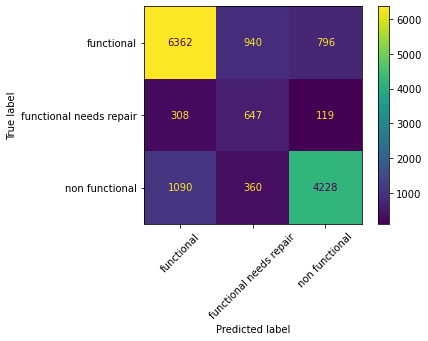

In [569]:
plot_confusion_matrix(random, X_test, y_test, xticks_rotation = 45);

In [562]:
# Save the model as a pickle in a file
joblib.dump(random, 'random_rfc.pkl')

['random_rfc.pkl']

#### Gridsearch based on randomized results

In [571]:
# Based on randomized search conduct one more gridsearch
params = {
          'rfc__n_estimators': [100],
          'rfc__min_samples_leaf': [2,3],
          'rfc__max_depth': [100, 150],
          'rfc__min_samples_split': [3, 5, 7],
          'rfc__max_features': ['auto']
}

gs_rfc_2 = GridSearchCV(estimator=rfc_model_pipe,
                 param_grid=params, n_jobs = -1,  
                 verbose = 2, cv = 3)
                 

In [572]:
gs_rfc_2.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 129.6min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         [0, 2,
                                                                          4, 5,
                                                                          12]),
                                                                        ('subpipe_cat',
                 

In [573]:
# Score the model on training data
gs_rfc_2.score(X_train, y_train)

0.8340291806958474

In [574]:
# examine best paramters
gs_rfc_2.best_params_

{'rfc__max_depth': 100,
 'rfc__max_features': 'auto',
 'rfc__min_samples_leaf': 2,
 'rfc__min_samples_split': 3,
 'rfc__n_estimators': 100}

In [575]:
# create predicted target using test set
y_hat_rfc_2 = gs_rfc_2.predict(X_test)

In [576]:
print(classification_report(y_test, y_hat_rfc_2))

                         precision    recall  f1-score   support

             functional       0.82      0.79      0.81      8098
functional needs repair       0.34      0.60      0.43      1074
         non functional       0.83      0.75      0.79      5678

               accuracy                           0.76     14850
              macro avg       0.66      0.71      0.67     14850
           weighted avg       0.79      0.76      0.77     14850



In [577]:
# select as final model
final_rfc_model = gs_rfc_2

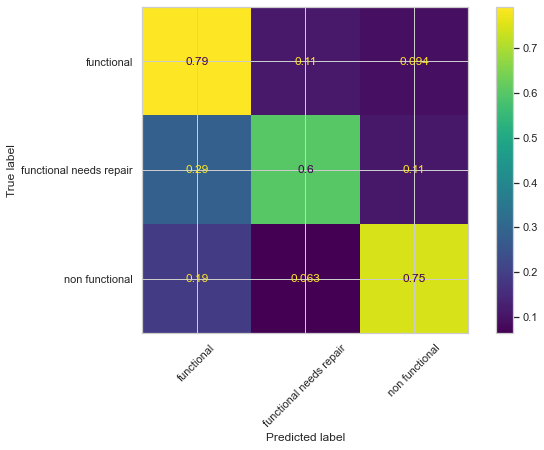

In [787]:
# Plot confusion matrix with percentages
plot_confusion_matrix(final_rfc_model, 
                      X_test, y_test, 
                      xticks_rotation = 45, 
                      normalize = 'true'
                     );

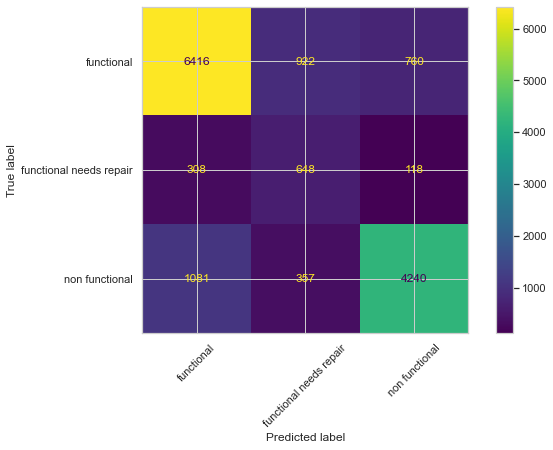

In [792]:
# Plot matrix with case numbers
plot_confusion_matrix(final_rfc_model, 
                      X_test, y_test, 
                      xticks_rotation = 45, 
                      
                     );

plt.savefig('final RFC model matrix')

In [579]:
# Save the model as a pickle in a file
joblib.dump(final_rfc_model, 'final_rfc_model.pkl')

['final_rfc_model.pkl']

### 5. Gradient Boost Model

Compare a default parameter gradient boost model against the RFC final model and select final model. 

In [184]:
# Gradient Boost model 
gbc_model_pipe = Pipeline([('ct', CT), ('gbc', GradientBoostingClassifier(random_state=42))])

gbc_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [0, 2, 4, 5, 12]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                             

In [185]:
gbc_model_pipe.score(X_train, y_train)

0.7612570145903479

In [186]:
y_hat_gbc = gbc_model_pipe.predict(X_test)

print(classification_report(y_test, y_hat_gbc))

                         precision    recall  f1-score   support

             functional       0.72      0.93      0.81      8098
functional needs repair       0.66      0.17      0.27      1074
         non functional       0.85      0.61      0.71      5678

               accuracy                           0.75     14850
              macro avg       0.74      0.57      0.60     14850
           weighted avg       0.76      0.75      0.73     14850



In [193]:
gbc_model_pipe.named_steps['gbc']

GradientBoostingClassifier(random_state=42)

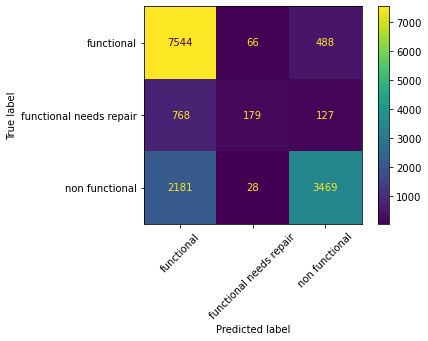

In [568]:
plot_confusion_matrix(gbc_model_pipe, X_test, y_test, xticks_rotation = 45);

In [565]:
# Save the model as a pickle in a file
joblib.dump(gbc_model_pipe, 'gbc_model.pkl')

['gbc_model.pkl']

### 6. Data Visualizations

Create three data visualizations to communicate findings to Water Aid.

In [797]:
# Examine full dataframe columns
df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

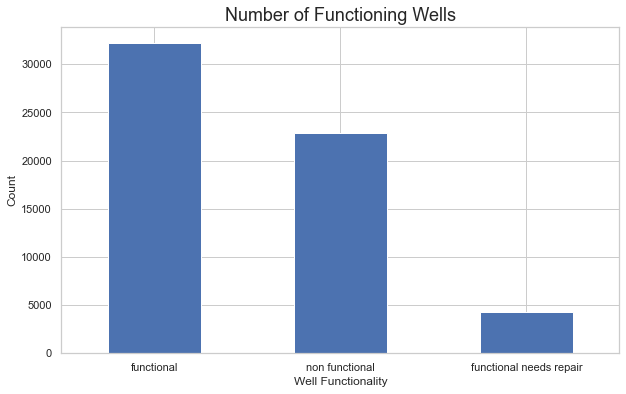

In [816]:
# Visualize well status count from dataset

df.status_group.value_counts().plot(kind="bar")
plt.title("Number of Functioning Wells",fontsize= 18)
plt.xlabel("Well Functionality", fontsize = 12)
plt.xticks(rotation=0)
plt.ylabel("Count", fontsize = 12)

plt.savefig('Number of Functioning Wells.png')

plt.show();



In [799]:
# Plot four shared cross country water basins in the region
# Plot visual showing basins and functional wells
df_basin = df[df['basin'].isin(['Lake Nyasa', 'Lake Victoria', 'Lake Tanganyika', 
                                'Ruvuma / Southern Coast',
                                ])]

In [800]:
df_basin.basin.value_counts()

Lake Victoria              10248
Lake Tanganyika             6432
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Name: basin, dtype: int64

In [801]:
df_basin.status_group.value_counts()

functional                 13201
non functional             10750
functional needs repair     2307
Name: status_group, dtype: int64

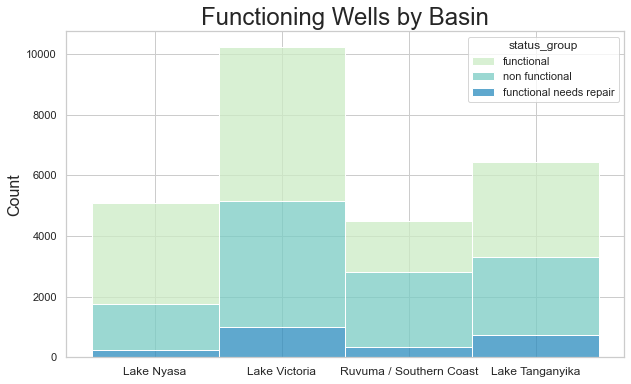

In [829]:
# Use Seaborn to and stacked histogram to show the four basins and well status

sns.set_theme()

sns.set(rc={"figure.figsize":(10, 6)})
sns.set_style('whitegrid')

sns.histplot(data = df_basin, x = 'basin', hue = 'status_group',
             bins = 10, binwidth = 6, palette = 'GnBu', legend = 'full', 
             multiple = 'stack')


plt.title("Functioning Wells by Basin",fontsize= 24)
plt.xlabel(None)
plt.ylabel("Count", fontsize = 16)
plt.xticks(rotation = 0, fontsize = 12)

plt.savefig('functioning wells by basin.png')

plt.show();



In [803]:
# Examine well status for two basin recommendations: Lake Victoria and Ruvuma
df_victoria = df[df['basin'].isin(['Lake Victoria'])]

df_victoria.status_group.value_counts()

functional                 5100
non functional             4159
functional needs repair     989
Name: status_group, dtype: int64

In [804]:
# Create dataframe for Ruvuma Basin
df_ruvuma = df[df['basin'].isin(['Ruvuma / Southern Coast'])]

#Examine well function status for Ruvuma Basin
print(df_ruvuma.status_group.value_counts(normalize = True))
print()
print(df_ruvuma.status_group.value_counts())

non functional             0.555753
functional                 0.371689
functional needs repair    0.072557
Name: status_group, dtype: float64

non functional             2497
functional                 1670
functional needs repair     326
Name: status_group, dtype: int64


In [805]:
df_ruvuma.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
26,55012,500.0,2013-01-16,Sobodo,200,Kilolo Star,39.370777,-9.942532,Ruhoma Primary School,0,...,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
46,45111,20.0,2013-02-05,Lga,240,LGA,39.087415,-11.000604,Mikoroshini,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional needs repair
91,62591,0.0,2013-01-20,Jica,212,Kokeni,38.962945,-10.476566,Maringini,0,...,salty,salty,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,non functional
98,33379,0.0,2013-02-19,Danida,1000,DWE,35.542173,-10.808853,Kwa Mathiasi,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional needs repair


In [806]:
#examine descriptive statistics for Ruvuma
df_ruvuma.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000
mean,37322.257067,228.390385,410.640329,38.316789,-10.485215,0.124861,52.386156,17.969508,274.193635,1899.780993
std,21489.456338,777.985990,338.566284,1.549237,0.591604,6.745120,38.834945,19.720254,445.829301,425.083164
min,19.000000,0.000000,-90.000000,34.889771,-11.649440,0.000000,8.000000,1.000000,0.000000,0.000000
25%,18908.000000,0.000000,164.000000,37.244214,-10.850966,0.000000,10.000000,2.000000,1.000000,1982.000000
50%,37228.000000,0.000000,342.000000,38.935668,-10.626269,0.000000,80.000000,5.000000,200.000000,1994.000000
75%,55874.000000,50.000000,585.000000,39.448147,-10.250908,0.000000,90.000000,33.000000,360.000000,2007.000000
max,74247.000000,15000.000000,1641.000000,40.345193,-8.496806,450.000000,99.000000,63.000000,8000.000000,2013.000000


In [807]:
# Build dataframe ruvuma basin with construction year
df_ruvuma_built = df_ruvuma[df_ruvuma.construction_year != 0]

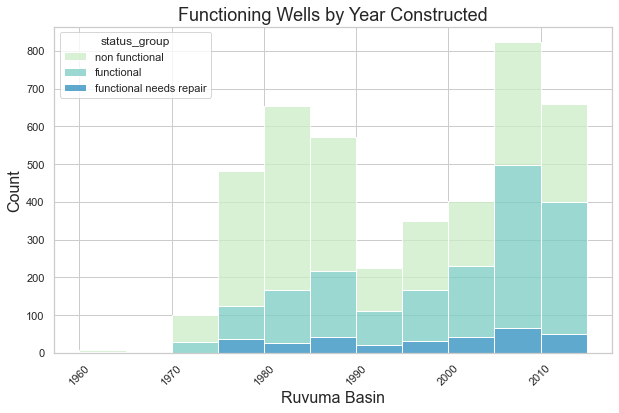

''

In [818]:
# Create data visualization, histogram, for functioning wells in Ruvuma
sns.set_theme()

sns.set(rc={"figure.figsize":(10, 6)})
sns.set_style('whitegrid')

sns.histplot(data = df_ruvuma_built, x = 'construction_year', hue = 'status_group',
             bins = 20, binwidth = 5, palette = 'GnBu', legend = 'full', 
             multiple = 'stack')


plt.title("Functioning Wells by Year Constructed",fontsize= 18)
plt.xlabel('Ruvuma Basin', fontsize = 16)
plt.xticks(rotation=0)
plt.ylabel("Count", fontsize = 16)
plt.xticks(rotation = 45)

plt.savefig('functioning wells ruvuma.png')

plt.show()

;

In [809]:
# Dataframe for older wells in Ruvuma, 1975 to 1990
df_ruvuma_old_wells = df_ruvuma.loc[(df_ruvuma.construction_year >= 1975) &
                                   (df_ruvuma.construction_year <= 1990)]

In [810]:
# Percentage of wells in need of repair
df_ruvuma_old_wells.status_group.value_counts(normalize = True)

non functional             0.699024
functional                 0.236646
functional needs repair    0.064331
Name: status_group, dtype: float64

## Final Summary

The initial Logistic Regression model with default parameters delivered the following scores: 

                                  precision recall  f1-score   support

         functional               0.78      0.88      0.83      8098
         functional needs repair  0.55      0.25      0.34      1074
         non functional           0.80      0.74      0.77      5678

               

The final Random Forest Classifier model with class imbalance adjustments and hyperparamater tuning delivered the following scores:

                                  precision recall  f1-score   support

         functional               0.82      0.79      0.81      8098
         functional needs repair  0.34      0.60      0.43      1074
         non functional           0.83      0.75      0.79      5678

The Random Forest Classifier was trained using both Randomized Search and Grid Search. Here are the final hyperparameter adjustments:

n_estimators = 100, (default)

max_depth = 100, 

max_features = 'auto', 

min_samples_leaf = 2, 

min_samples_split = 3


The precision scores increased by 4% for functional wells and increased by 3% for non-functional wells. The precision score fell quite dramatically by 21% for wells in need of repair. This may be due to wells in need of repair often being classified as functioning wells, their features appear to look much like functioning wells. Despite this the recall score for wells in need of repair improved dramatically, by 35%. 

The improved model delivers trade offs. As precision scores increase for functional and non-functional wells, precision for wells in need of repair decreases. But, it needs to be noted, recall for wells in need of repair increases. 

Water Aid's use of the model will be primarily for precision -  true positive identification for functioning and non-functioning wells. They can still make use of the model for wells in need of repair, but the results for that class need to be understood in terms of recall - the ability of a model to find all the relevant cases within a data set.
             

## Recommendations

#### 1.  Model Use

Wells in shared basins should make use of the model's precision metric to accurately identify non-functioning wells. Chances are 83% that they will be right which will help in making use of programming resources to repair the wells. 

#### 2. Basin Location

The model makes significant use of data in Tanzanian water basins that also span nearby countries. The Ruvuma Basin stretches from southern Tanzania to northern Mozambique. The Ruvuma basin contains more than 55% nonfunctioning wells and over 7% of wells need repair. Considering Water Aid has a presence in both countries, and efforts by other NGOs and governments of both countries to manage this space along transboundary lines, the Ruvuma basin offers an opportunity to make an impact using this model.

#### 3. Well Age

In the Ruvuma Basin the proportion of older wells in need of repair compared to newer wells in need of repair is much higher. Wells built between 1975 to 1990 should be targeted first. These older non-functional wells account for nearly 70% of all wells built during this time frame. 